In [29]:
from typing import Dict, List, Tuple
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from modular_classification import (data_setup, 
                                    engine)
from modular_classification.engine import (test_func,
                                           train_func )                                
import torchinfo
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def set_seed(seed: int=23):
    """
    Sets a specific seed for the tests
    
    Args:
        seed (int, optional): Random seed to set. Defaults is 23.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [62]:
test_dir= "./datasets/pizza_sushi/test"
train_dir = "./datasets/pizza_sushi/train"
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir
                                                                               , test_dir=test_dir
                                                                                ,transform=auto_transforms,
                                                                                  batch_size=32)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)                                                                          
for param in model.features.parameters():
    param.requires_grad = False

set_seed()

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), #We dont change this variable
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
train_dataloader.dataset, test_dataloader.dataset

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: ./datasets/pizza_sushi/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: ./datasets/pizza_sushi/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


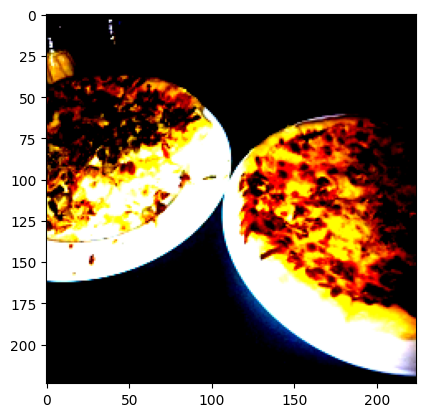

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


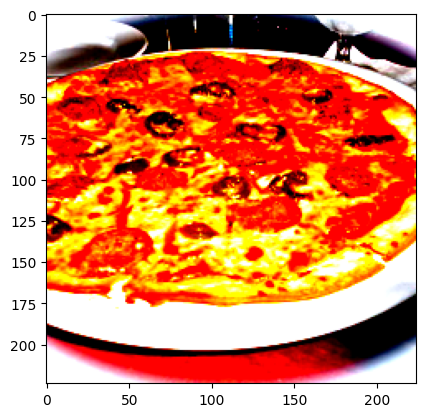

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


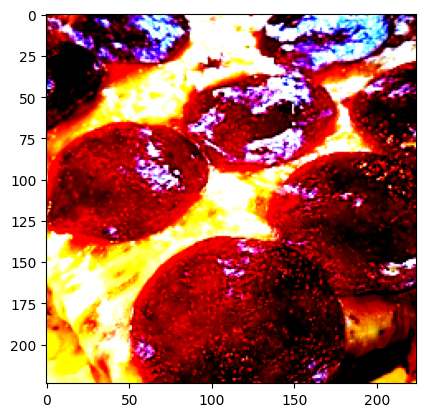

In [6]:
for i in range(3):
    img = next(iter(train_dataloader))[0][i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [6]:
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    └─Sequential (2)                                        --                        False
│    │    └─MBConv (0)                                       (6,004

In [9]:
writer = SummaryWriter()

We need to modify our existing train and test function to integrate the write funtion of the tensorboard writer, its usage is **writer.add_scalars(main_tag, tag_scalar_dict)** \
main_tag = the metric
tag scalar = a dict with the results like {"train_loss": int}

In [10]:
def train(model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
        optimizer: torch.optim.Optimizer, device: torch.device, epochs: int) -> Dict[str, List]:
    """
    Trains and test a Pytorch model

    Args:
    -----
        model: A Pytorch model
        train_data: a DataLoader object with the train data
        test_data: a DataLoader object with the train data
        loss_fn: loss function to minimized
        optimizer: A Pytorch optimizer
        device: A target device to perform the operations ("cuda" or "cpu")
        epochs: A integre with the number of epochs that the model will be train
    Returns:
    --------
        A dictionary with the train and test loss and accuracy for every epoch
        in the form of 
        {"train_loss": [...],
        "train_acc": [...],
        "test_loss": [...],
        "test_acc": [...]}
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_func(
            model,train_data,loss_fn,optimizer, device)
        test_loss, test_acc = test_func(
            model, test_data, loss_fn, device)
        print(
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} "
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ##Add of the writer
        writer.add_scalars(main_tag="Loss", 
        tag_scalar_dict={"train_loss": train_loss, "tests_loss": test_loss},
        global_step=epoch
        )

        writer.add_scalars(main_tag="Accuracy", 
        tag_scalar_dict={"train_acc": train_acc, "tests_acc": test_acc},
        global_step=epoch
        )

        writer.close()
    return results

In [11]:
set_seed()
results = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.0369 |train_acc : 0.4292 |test_loss : 1.0086 |test_acc : 0.4648 
Epoch 2 |train_loss : 1.2376 |train_acc : 0.3125 |test_loss : 1.0068 |test_acc : 0.4761 
Epoch 3 |train_loss : 1.2476 |train_acc : 0.1625 |test_loss : 1.0091 |test_acc : 0.5312 
Epoch 4 |train_loss : 1.1941 |train_acc : 0.1750 |test_loss : 0.9937 |test_acc : 0.5813 
Epoch 5 |train_loss : 1.1676 |train_acc : 0.2229 |test_loss : 0.9801 |test_acc : 0.5813 
Epoch 6 |train_loss : 1.1839 |train_acc : 0.2542 |test_loss : 0.9750 |test_acc : 0.6062 
Epoch 7 |train_loss : 1.1681 |train_acc : 0.2625 |test_loss : 0.9671 |test_acc : 0.6125 
Epoch 8 |train_loss : 1.1672 |train_acc : 0.2729 |test_loss : 0.9622 |test_acc : 0.6250 
Epoch 9 |train_loss : 1.1679 |train_acc : 0.2771 |test_loss : 0.9551 |test_acc : 0.6250 
Epoch 10 |train_loss : 1.1678 |train_acc : 0.2917 |test_loss : 0.9524 |test_acc : 0.6250 


In [13]:
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    └─Sequential (2)                                        --                        False
│    │    └─MBConv (0)                                       (6,004

Lets defying a function that creates a writer base in time and other parameters

In [24]:
def create_write(name: str, model: str, extra: str=None) -> SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, name, model, extra)
    else:
        log_dir = os.path.join("runs", timestamp, name, model)
    print(f"[INFO] create summary writer, saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

Updating the train function

### Train function with a profiler

To look up time spendind in every action an see what steps would need a optimization

In [10]:
def train_func_profiler(model: nn.Module, data: DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device
               , log_dir: str) -> Tuple[float, float]:
    """
    Trains a model for a single epoch

    Args
    ----
        model: A Pytorch model
        data: a DataLoader object with the train data
        loss_fn: loss function to minimized
        optimizer: A Pytorch optimizer
        device: A target device to perform the operations ("cuda" or "cpu")

    Returns
    ------
        A tuple with the loss and accuracy of the training epoch like
        (train_loss, train_acc)
    """
    def trace_handler(prof):
        print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))

    model.train()
    train_loss, train_acc = 0, 0
    with torch.profiler.profile(
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=1,
            repeat=1),
        #on_trace_ready=trace_handler,
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./log"),
        with_stack=True
    ) as profiler:
        for _ , (x, y) in enumerate(data):
            x, y = x.to(device), y.to(device)
            y_logit = model(x)
            loss = loss_fn(y_logit, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            profiler.step()
            y_pred = torch.softmax(y_logit, 1).argmax(1)
            train_acc += (y_pred == y).sum().item() / len (y_pred)
            #We can use another function if we want
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)
    return train_loss, train_acc

In [25]:
def train(model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
        optimizer: torch.optim.Optimizer, device: torch.device, epochs: int
        , writer: SummaryWriter) -> Dict[str, List]:
    """
    Trains and test a Pytorch model

    Args:
    -----
        model: A Pytorch model
        train_data: a DataLoader object with the train data
        test_data: a DataLoader object with the train data
        loss_fn: loss function to minimized
        optimizer: A Pytorch optimizer
        device: A target device to perform the operations ("cuda" or "cpu")
        epochs: A integre with the number of epochs that the model will be train
    Returns:
    --------
        A dictionary with the train and test loss and accuracy for every epoch
        in the form of 
        {"train_loss": [...],
        "train_acc": [...],
        "test_loss": [...],
        "test_acc": [...]}
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_func(
            model,train_data,loss_fn,optimizer, device)
        test_loss, test_acc = test_func(
            model, test_data, loss_fn, device)
        print(
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} "
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ##Add of the writer
        if writer:
            writer.add_scalars(main_tag="Loss", 
            tag_scalar_dict={"train_loss": train_loss, "tests_loss": test_loss},
            global_step=epoch
            )

            writer.add_scalars(main_tag="Accuracy", 
            tag_scalar_dict={"train_acc": train_acc, "tests_acc": test_acc},
            global_step=epoch
            )

            writer.close()
    return results

Lets do some experiments with both the models and using different optimiztors, changing the epochs

In [59]:
OUT_FEATURES = len(class_names)

def create_effntb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), #We dont change this variable
        torch.nn.Linear(in_features=1280, out_features=OUT_FEATURES, bias=True)
    ).to(device)
    print(f"[INFO] create new effntb0 model.")
    return model

def create_effntb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.3, inplace=True), #We dont change this variable
        torch.nn.Linear(in_features=1408, out_features=OUT_FEATURES, bias=True)
    ).to(device)
    print(f"[INFO] create new effntb2 model.")
    return model

def create_convnext_tiny():
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights).to(device)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=OUT_FEATURES, bias=True)
    ).to(device)
    print(f"[INFO] create new convnext_tiny model.")
    return model

def create_convnext_small():
    weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
    model = torchvision.models.convnext_small(weights=weights).to(device)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=OUT_FEATURES, bias=True)
    ).to(device)
    print(f"[INFO] create new convnext_small model.")
    return model

In [73]:
def select_optimizer(model: nn.Module, optimizer: str):
    if optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer == "SGD": 
        return torch.optim.SGD(model.parameters(), lr=0.001)
    elif optimizer == "Adamw":
        return torch.optim.AdamW(model.parameters(), lr=0.001)

In [15]:
torchinfo.summary(effnetb2, (32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    │    └─MBConv (1)                                       (612)                     False
│    └─Sequential (2)                                        --    

Create the list with the information that we want to iterate

In [71]:
num_epochs = [2, 5, 10]
models_names = ["effnetb0", "effnetb2", "convnext_tiny", "convnext_small"]
optimizers = ["Adam", "SGD", "Adamw"]

We are going to use the same size and transformation for all the models for the sake of consistency

In [74]:
set_seed()

experiment_number = 0
model_num = 0
loss_fn = nn.CrossEntropyLoss().to(device)
timestamp = datetime.now().strftime("%Y-%m-%d")

for epochs in num_epochs:
    for model_name in models_names:
        for optimizer_name in optimizers:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] model: {model_name}")
            print(f"[INFO] Optimizer: {optimizer_name}")
            print(f"[INFO] Epochs: {epochs}")
            if model_name == "effnetb0":
                model = create_effntb0()
            elif model_name == "effnetb2":
                model = create_effntb2()
            elif model_name == "convnext_tiny":
                model = create_convnext_tiny()
            elif model_name == "convnext_small":
                model = create_convnext_small()
            writer = create_write(name=optimizer_name, 
            model=model_name, extra=str(epochs))
            #log_dir = os.path.join("log", timestamp + optimizer + name + str(epochs))
            optimizer = select_optimizer(model, optimizer_name)
            results = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device,
            epochs, writer)
            print("-" * 50 + "\n")

[INFO] Experiment number: 1
[INFO] model: effnetb0
[INFO] Optimizer: Adam
[INFO] Epochs: 2
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/effnetb0/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7748 |train_acc : 0.2521 |test_loss : 1.3398 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] model: effnetb0
[INFO] Optimizer: SGD
[INFO] Epochs: 2
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/effnetb0/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1321 |train_acc : 0.3479 |test_loss : 1.0735 |test_acc : 0.4426 
Epoch 2 |train_loss : 1.1231 |train_acc : 0.3083 |test_loss : 1.0660 |test_acc : 0.4205 
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] model: effnetb0
[INFO] Optimizer: Adamw
[INFO] Epochs: 2
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/effnetb0/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7747 |train_acc : 0.2521 |test_loss : 1.3397 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] model: effnetb2
[INFO] Optimizer: Adam
[INFO] Epochs: 2
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/effnetb2/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7821 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] model: effnetb2
[INFO] Optimizer: SGD
[INFO] Epochs: 2
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/effnetb2/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1177 |train_acc : 0.2938 |test_loss : 1.0983 |test_acc : 0.3898 
Epoch 2 |train_loss : 1.1257 |train_acc : 0.3000 |test_loss : 1.0995 |test_acc : 0.3489 
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] model: effnetb2
[INFO] Optimizer: Adamw
[INFO] Epochs: 2
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/effnetb2/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7820 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] model: convnext_tiny
[INFO] Optimizer: Adam
[INFO] Epochs: 2
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/convnext_tiny/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4229 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3426 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] model: convnext_tiny
[INFO] Optimizer: SGD
[INFO] Epochs: 2
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/convnext_tiny/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.0138 |train_acc : 0.5312 |test_loss : 0.9019 |test_acc : 0.6131 
Epoch 2 |train_loss : 0.8182 |train_acc : 0.6583 |test_loss : 0.7202 |test_acc : 0.6659 
--------------------------------------------------

[INFO] Experiment number: 9
[INFO] model: convnext_tiny
[INFO] Optimizer: Adamw
[INFO] Epochs: 2
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/convnext_tiny/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4228 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3427 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
--------------------------------------------------

[INFO] Experiment number: 10
[INFO] model: convnext_small
[INFO] Optimizer: Adam
[INFO] Epochs: 2
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/convnext_small/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4667 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3609 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
--------------------------------------------------

[INFO] Experiment number: 11
[INFO] model: convnext_small
[INFO] Optimizer: SGD
[INFO] Epochs: 2
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/convnext_small/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1304 |train_acc : 0.4542 |test_loss : 0.9903 |test_acc : 0.3881 
Epoch 2 |train_loss : 0.9044 |train_acc : 0.6125 |test_loss : 0.7646 |test_acc : 0.7000 
--------------------------------------------------

[INFO] Experiment number: 12
[INFO] model: convnext_small
[INFO] Optimizer: Adamw
[INFO] Epochs: 2
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/convnext_small/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4666 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3610 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
--------------------------------------------------

[INFO] Experiment number: 13
[INFO] model: effnetb0
[INFO] Optimizer: Adam
[INFO] Epochs: 5
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/effnetb0/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7748 |train_acc : 0.2521 |test_loss : 1.3398 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
Epoch 3 |train_loss : 1.2310 |train_acc : 0.3146 |test_loss : 1.0018 |test_acc : 0.5011 
Epoch 4 |train_loss : 1.2538 |train_acc : 0.1521 |test_loss : 1.0056 |test_acc : 0.5750 
Epoch 5 |train_loss : 1.1793 |train_acc : 0.1938 |test_loss : 0.9924 |test_acc : 0.5750 
--------------------------------------------------

[INFO] Experiment number: 14
[INFO] model: effnetb0
[INFO] Optimizer: SGD
[INFO] Epochs: 5
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/effnetb0/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1321 |train_acc : 0.3479 |test_loss : 1.0735 |test_acc : 0.4426 
Epoch 2 |train_loss : 1.1231 |train_acc : 0.3083 |test_loss : 1.0660 |test_acc : 0.4205 
Epoch 3 |train_loss : 1.1161 |train_acc : 0.3250 |test_loss : 1.0620 |test_acc : 0.4267 
Epoch 4 |train_loss : 1.1193 |train_acc : 0.3146 |test_loss : 1.0588 |test_acc : 0.4170 
Epoch 5 |train_loss : 1.1082 |train_acc : 0.2938 |test_loss : 1.0580 |test_acc : 0.4170 
--------------------------------------------------

[INFO] Experiment number: 15
[INFO] model: effnetb0
[INFO] Optimizer: Adamw
[INFO] Epochs: 5
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/effnetb0/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7747 |train_acc : 0.2521 |test_loss : 1.3397 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
Epoch 3 |train_loss : 1.2310 |train_acc : 0.3146 |test_loss : 1.0018 |test_acc : 0.5011 
Epoch 4 |train_loss : 1.2538 |train_acc : 0.1521 |test_loss : 1.0056 |test_acc : 0.5750 
Epoch 5 |train_loss : 1.1793 |train_acc : 0.1938 |test_loss : 0.9924 |test_acc : 0.5750 
--------------------------------------------------

[INFO] Experiment number: 16
[INFO] model: effnetb2
[INFO] Optimizer: Adam
[INFO] Epochs: 5
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/effnetb2/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7821 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
Epoch 3 |train_loss : 1.2253 |train_acc : 0.3187 |test_loss : 1.0436 |test_acc : 0.4545 
Epoch 4 |train_loss : 1.2577 |train_acc : 0.2125 |test_loss : 1.0442 |test_acc : 0.4909 
Epoch 5 |train_loss : 1.1849 |train_acc : 0.2333 |test_loss : 1.0304 |test_acc : 0.5250 
--------------------------------------------------

[INFO] Experiment number: 17
[INFO] model: effnetb2
[INFO] Optimizer: SGD
[INFO] Epochs: 5
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/effnetb2/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1177 |train_acc : 0.2938 |test_loss : 1.0983 |test_acc : 0.3898 
Epoch 2 |train_loss : 1.1257 |train_acc : 0.3000 |test_loss : 1.0995 |test_acc : 0.3489 
Epoch 3 |train_loss : 1.1109 |train_acc : 0.3250 |test_loss : 1.0966 |test_acc : 0.3483 
Epoch 4 |train_loss : 1.1160 |train_acc : 0.3375 |test_loss : 1.0948 |test_acc : 0.3483 
Epoch 5 |train_loss : 1.1066 |train_acc : 0.3521 |test_loss : 1.0937 |test_acc : 0.3659 
--------------------------------------------------

[INFO] Experiment number: 18
[INFO] model: effnetb2
[INFO] Optimizer: Adamw
[INFO] Epochs: 5
[INFO] create new effntb2 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/effnetb2/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7820 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
Epoch 3 |train_loss : 1.2253 |train_acc : 0.3187 |test_loss : 1.0436 |test_acc : 0.4545 
Epoch 4 |train_loss : 1.2576 |train_acc : 0.2125 |test_loss : 1.0442 |test_acc : 0.4909 
Epoch 5 |train_loss : 1.1849 |train_acc : 0.2333 |test_loss : 1.0304 |test_acc : 0.5250 
--------------------------------------------------

[INFO] Experiment number: 19
[INFO] model: convnext_tiny
[INFO] Optimizer: Adam
[INFO] Epochs: 5
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/convnext_tiny/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4229 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3426 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
Epoch 3 |train_loss : 0.2880 |train_acc : 0.9187 |test_loss : 0.1765 |test_acc : 0.9631 
Epoch 4 |train_loss : 0.2250 |train_acc : 0.9271 |test_loss : 0.1518 |test_acc : 0.9602 
Epoch 5 |train_loss : 0.1678 |train_acc : 0.9500 |test_loss : 0.1373 |test_acc : 0.9602 
--------------------------------------------------

[INFO] Experiment number: 20
[INFO] model: convnext_tiny
[INFO] Optimizer: SGD
[INFO] Epochs: 5
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/convnext_tiny/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.0138 |train_acc : 0.5312 |test_loss : 0.9019 |test_acc : 0.6131 
Epoch 2 |train_loss : 0.8182 |train_acc : 0.6583 |test_loss : 0.7202 |test_acc : 0.6659 
Epoch 3 |train_loss : 0.6776 |train_acc : 0.7458 |test_loss : 0.5910 |test_acc : 0.7722 
Epoch 4 |train_loss : 0.5767 |train_acc : 0.8229 |test_loss : 0.5023 |test_acc : 0.8313 
Epoch 5 |train_loss : 0.4977 |train_acc : 0.8583 |test_loss : 0.4380 |test_acc : 0.8659 
--------------------------------------------------

[INFO] Experiment number: 21
[INFO] model: convnext_tiny
[INFO] Optimizer: Adamw
[INFO] Epochs: 5
[INFO] create new convnext_tiny model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/convnext_tiny/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4228 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3427 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
Epoch 3 |train_loss : 0.2881 |train_acc : 0.9187 |test_loss : 0.1766 |test_acc : 0.9631 
Epoch 4 |train_loss : 0.2251 |train_acc : 0.9271 |test_loss : 0.1519 |test_acc : 0.9602 
Epoch 5 |train_loss : 0.1680 |train_acc : 0.9500 |test_loss : 0.1374 |test_acc : 0.9602 
--------------------------------------------------

[INFO] Experiment number: 22
[INFO] model: convnext_small
[INFO] Optimizer: Adam
[INFO] Epochs: 5
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/convnext_small/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4667 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3609 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
Epoch 3 |train_loss : 0.2882 |train_acc : 0.9104 |test_loss : 0.1443 |test_acc : 0.9722 
Epoch 4 |train_loss : 0.2267 |train_acc : 0.9396 |test_loss : 0.1176 |test_acc : 0.9847 
Epoch 5 |train_loss : 0.1763 |train_acc : 0.9625 |test_loss : 0.0992 |test_acc : 0.9847 
--------------------------------------------------

[INFO] Experiment number: 23
[INFO] model: convnext_small
[INFO] Optimizer: SGD
[INFO] Epochs: 5
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/SGD/convnext_small/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1304 |train_acc : 0.4542 |test_loss : 0.9903 |test_acc : 0.3881 
Epoch 2 |train_loss : 0.9044 |train_acc : 0.6125 |test_loss : 0.7646 |test_acc : 0.7000 
Epoch 3 |train_loss : 0.7300 |train_acc : 0.7208 |test_loss : 0.6131 |test_acc : 0.7625 
Epoch 4 |train_loss : 0.6414 |train_acc : 0.7792 |test_loss : 0.5232 |test_acc : 0.7937 
Epoch 5 |train_loss : 0.5750 |train_acc : 0.8333 |test_loss : 0.4346 |test_acc : 0.8812 
--------------------------------------------------

[INFO] Experiment number: 24
[INFO] model: convnext_small
[INFO] Optimizer: Adamw
[INFO] Epochs: 5
[INFO] create new convnext_small model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adamw/convnext_small/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4666 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3610 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
Epoch 3 |train_loss : 0.2883 |train_acc : 0.9104 |test_loss : 0.1444 |test_acc : 0.9722 
Epoch 4 |train_loss : 0.2268 |train_acc : 0.9396 |test_loss : 0.1177 |test_acc : 0.9847 
Epoch 5 |train_loss : 0.1764 |train_acc : 0.9625 |test_loss : 0.0993 |test_acc : 0.9847 
--------------------------------------------------

[INFO] Experiment number: 25
[INFO] model: effnetb0
[INFO] Optimizer: Adam
[INFO] Epochs: 10
[INFO] create new effntb0 model.
[INFO] create summary writer, saving to: runs/2024-08-23/Adam/effnetb0/10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7748 |train_acc : 0.2521 |test_loss : 1.3398 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
Epoch 3 |train_loss : 1.2310 |train_acc : 0.3146 |test_loss : 1.0018 |test_acc : 0.5011 
Epoch 4 |train_loss : 1.2538 |train_acc : 0.1521 |test_loss : 1.0056 |test_acc : 0.5750 
Epoch 5 |train_loss : 1.1793 |train_acc : 0.1938 |test_loss : 0.9924 |test_acc : 0.5750 
Epoch 6 |train_loss : 1.1775 |train_acc : 0.2479 |test_loss : 0.9811 |test_acc : 0.5875 
Epoch 7 |train_loss : 1.1732 |train_acc : 0.2604 |test_loss : 0.9726 |test_acc : 0.5938 
Epoch 8 |train_loss : 1.1750 |train_acc : 0.2604 |test_loss : 0.9681 |test_acc : 0.6125 
Epoch 9 |train_loss : 1.1725 |train_acc : 0.2750 |test_loss : 0.9601 |test_acc : 0.6062 
Epoch 10 |train_loss : 1.1721 |train_acc : 0.2833 |test_loss : 0.9569 |test_acc : 0.6278 
--------------------------------------------------

[INFO] Experiment number: 26
[INFO] model: effnetb0
[INFO

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1321 |train_acc : 0.3479 |test_loss : 1.0735 |test_acc : 0.4426 
Epoch 2 |train_loss : 1.1231 |train_acc : 0.3083 |test_loss : 1.0660 |test_acc : 0.4205 
Epoch 3 |train_loss : 1.1161 |train_acc : 0.3250 |test_loss : 1.0620 |test_acc : 0.4267 
Epoch 4 |train_loss : 1.1193 |train_acc : 0.3146 |test_loss : 1.0588 |test_acc : 0.4170 
Epoch 5 |train_loss : 1.1082 |train_acc : 0.2938 |test_loss : 1.0580 |test_acc : 0.4170 
Epoch 6 |train_loss : 1.1118 |train_acc : 0.3729 |test_loss : 1.0574 |test_acc : 0.4324 
Epoch 7 |train_loss : 1.1036 |train_acc : 0.3729 |test_loss : 1.0550 |test_acc : 0.4415 
Epoch 8 |train_loss : 1.1118 |train_acc : 0.3458 |test_loss : 1.0542 |test_acc : 0.4290 
Epoch 9 |train_loss : 1.1147 |train_acc : 0.3229 |test_loss : 1.0507 |test_acc : 0.4437 
Epoch 10 |train_loss : 1.1148 |train_acc : 0.3563 |test_loss : 1.0517 |test_acc : 0.4347 
--------------------------------------------------

[INFO] Experiment number: 27
[INFO] model: effnetb0
[INFO

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7747 |train_acc : 0.2521 |test_loss : 1.3397 |test_acc : 0.3625 
Epoch 2 |train_loss : 1.0484 |train_acc : 0.3875 |test_loss : 1.0097 |test_acc : 0.4528 
Epoch 3 |train_loss : 1.2310 |train_acc : 0.3146 |test_loss : 1.0018 |test_acc : 0.5011 
Epoch 4 |train_loss : 1.2538 |train_acc : 0.1521 |test_loss : 1.0056 |test_acc : 0.5750 
Epoch 5 |train_loss : 1.1793 |train_acc : 0.1938 |test_loss : 0.9924 |test_acc : 0.5750 
Epoch 6 |train_loss : 1.1775 |train_acc : 0.2479 |test_loss : 0.9812 |test_acc : 0.5875 
Epoch 7 |train_loss : 1.1732 |train_acc : 0.2604 |test_loss : 0.9726 |test_acc : 0.5938 
Epoch 8 |train_loss : 1.1750 |train_acc : 0.2604 |test_loss : 0.9681 |test_acc : 0.6125 
Epoch 9 |train_loss : 1.1725 |train_acc : 0.2750 |test_loss : 0.9601 |test_acc : 0.6062 
Epoch 10 |train_loss : 1.1721 |train_acc : 0.2833 |test_loss : 0.9569 |test_acc : 0.6278 
--------------------------------------------------

[INFO] Experiment number: 28
[INFO] model: effnetb2
[INFO

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7821 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
Epoch 3 |train_loss : 1.2253 |train_acc : 0.3187 |test_loss : 1.0436 |test_acc : 0.4545 
Epoch 4 |train_loss : 1.2577 |train_acc : 0.2125 |test_loss : 1.0442 |test_acc : 0.4909 
Epoch 5 |train_loss : 1.1849 |train_acc : 0.2333 |test_loss : 1.0304 |test_acc : 0.5250 
Epoch 6 |train_loss : 1.1810 |train_acc : 0.2708 |test_loss : 1.0149 |test_acc : 0.5801 
Epoch 7 |train_loss : 1.1857 |train_acc : 0.2729 |test_loss : 1.0058 |test_acc : 0.5898 
Epoch 8 |train_loss : 1.1844 |train_acc : 0.2583 |test_loss : 0.9956 |test_acc : 0.6085 
Epoch 9 |train_loss : 1.1851 |train_acc : 0.2458 |test_loss : 0.9901 |test_acc : 0.5960 
Epoch 10 |train_loss : 1.1637 |train_acc : 0.2792 |test_loss : 0.9832 |test_acc : 0.6051 
--------------------------------------------------

[INFO] Experiment number: 29
[INFO] model: effnetb2
[INFO

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1177 |train_acc : 0.2938 |test_loss : 1.0983 |test_acc : 0.3898 
Epoch 2 |train_loss : 1.1257 |train_acc : 0.3000 |test_loss : 1.0995 |test_acc : 0.3489 
Epoch 3 |train_loss : 1.1109 |train_acc : 0.3250 |test_loss : 1.0966 |test_acc : 0.3483 
Epoch 4 |train_loss : 1.1160 |train_acc : 0.3375 |test_loss : 1.0948 |test_acc : 0.3483 
Epoch 5 |train_loss : 1.1066 |train_acc : 0.3521 |test_loss : 1.0937 |test_acc : 0.3659 
Epoch 6 |train_loss : 1.1101 |train_acc : 0.3500 |test_loss : 1.0914 |test_acc : 0.3875 
Epoch 7 |train_loss : 1.1101 |train_acc : 0.3667 |test_loss : 1.0914 |test_acc : 0.3688 
Epoch 8 |train_loss : 1.1038 |train_acc : 0.3771 |test_loss : 1.0886 |test_acc : 0.4051 
Epoch 9 |train_loss : 1.1181 |train_acc : 0.3458 |test_loss : 1.0868 |test_acc : 0.4023 
Epoch 10 |train_loss : 1.0967 |train_acc : 0.3646 |test_loss : 1.0864 |test_acc : 0.4051 
--------------------------------------------------

[INFO] Experiment number: 30
[INFO] model: effnetb2
[INFO

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.7820 |train_acc : 0.2625 |test_loss : 1.2120 |test_acc : 0.3438 
Epoch 2 |train_loss : 1.0481 |train_acc : 0.4000 |test_loss : 1.0425 |test_acc : 0.4750 
Epoch 3 |train_loss : 1.2253 |train_acc : 0.3187 |test_loss : 1.0436 |test_acc : 0.4545 
Epoch 4 |train_loss : 1.2576 |train_acc : 0.2125 |test_loss : 1.0442 |test_acc : 0.4909 
Epoch 5 |train_loss : 1.1849 |train_acc : 0.2333 |test_loss : 1.0304 |test_acc : 0.5250 
Epoch 6 |train_loss : 1.1810 |train_acc : 0.2708 |test_loss : 1.0149 |test_acc : 0.5801 
Epoch 7 |train_loss : 1.1857 |train_acc : 0.2729 |test_loss : 1.0058 |test_acc : 0.5898 
Epoch 8 |train_loss : 1.1844 |train_acc : 0.2583 |test_loss : 0.9956 |test_acc : 0.6085 
Epoch 9 |train_loss : 1.1851 |train_acc : 0.2458 |test_loss : 0.9901 |test_acc : 0.5960 
Epoch 10 |train_loss : 1.1637 |train_acc : 0.2792 |test_loss : 0.9833 |test_acc : 0.6051 
--------------------------------------------------

[INFO] Experiment number: 31
[INFO] model: convnext_tiny


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4229 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3426 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
Epoch 3 |train_loss : 0.2880 |train_acc : 0.9187 |test_loss : 0.1765 |test_acc : 0.9631 
Epoch 4 |train_loss : 0.2250 |train_acc : 0.9271 |test_loss : 0.1518 |test_acc : 0.9602 
Epoch 5 |train_loss : 0.1678 |train_acc : 0.9500 |test_loss : 0.1373 |test_acc : 0.9602 
Epoch 6 |train_loss : 0.1456 |train_acc : 0.9604 |test_loss : 0.1266 |test_acc : 0.9602 
Epoch 7 |train_loss : 0.1364 |train_acc : 0.9646 |test_loss : 0.1188 |test_acc : 0.9602 
Epoch 8 |train_loss : 0.1189 |train_acc : 0.9729 |test_loss : 0.1128 |test_acc : 0.9602 
Epoch 9 |train_loss : 0.1134 |train_acc : 0.9688 |test_loss : 0.1080 |test_acc : 0.9602 
Epoch 10 |train_loss : 0.1051 |train_acc : 0.9729 |test_loss : 0.1038 |test_acc : 0.9602 
--------------------------------------------------

[INFO] Experiment number: 32
[INFO] model: convnext_tiny


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.0138 |train_acc : 0.5312 |test_loss : 0.9019 |test_acc : 0.6131 
Epoch 2 |train_loss : 0.8182 |train_acc : 0.6583 |test_loss : 0.7202 |test_acc : 0.6659 
Epoch 3 |train_loss : 0.6776 |train_acc : 0.7458 |test_loss : 0.5910 |test_acc : 0.7722 
Epoch 4 |train_loss : 0.5767 |train_acc : 0.8229 |test_loss : 0.5023 |test_acc : 0.8313 
Epoch 5 |train_loss : 0.4977 |train_acc : 0.8583 |test_loss : 0.4380 |test_acc : 0.8659 
Epoch 6 |train_loss : 0.4609 |train_acc : 0.8792 |test_loss : 0.3928 |test_acc : 0.8909 
Epoch 7 |train_loss : 0.4284 |train_acc : 0.8854 |test_loss : 0.3573 |test_acc : 0.8881 
Epoch 8 |train_loss : 0.3877 |train_acc : 0.8958 |test_loss : 0.3278 |test_acc : 0.9131 
Epoch 9 |train_loss : 0.3708 |train_acc : 0.9250 |test_loss : 0.3026 |test_acc : 0.9256 
Epoch 10 |train_loss : 0.3490 |train_acc : 0.9292 |test_loss : 0.2854 |test_acc : 0.9256 
--------------------------------------------------

[INFO] Experiment number: 33
[INFO] model: convnext_tiny


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4228 |train_acc : 0.3479 |test_loss : 0.6755 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3427 |train_acc : 0.9229 |test_loss : 0.2531 |test_acc : 0.9568 
Epoch 3 |train_loss : 0.2881 |train_acc : 0.9187 |test_loss : 0.1766 |test_acc : 0.9631 
Epoch 4 |train_loss : 0.2251 |train_acc : 0.9271 |test_loss : 0.1519 |test_acc : 0.9602 
Epoch 5 |train_loss : 0.1680 |train_acc : 0.9500 |test_loss : 0.1374 |test_acc : 0.9602 
Epoch 6 |train_loss : 0.1458 |train_acc : 0.9604 |test_loss : 0.1267 |test_acc : 0.9602 
Epoch 7 |train_loss : 0.1366 |train_acc : 0.9646 |test_loss : 0.1189 |test_acc : 0.9602 
Epoch 8 |train_loss : 0.1191 |train_acc : 0.9729 |test_loss : 0.1129 |test_acc : 0.9602 
Epoch 9 |train_loss : 0.1136 |train_acc : 0.9688 |test_loss : 0.1082 |test_acc : 0.9602 
Epoch 10 |train_loss : 0.1053 |train_acc : 0.9729 |test_loss : 0.1039 |test_acc : 0.9602 
--------------------------------------------------

[INFO] Experiment number: 34
[INFO] model: convnext_small

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4667 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3609 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
Epoch 3 |train_loss : 0.2882 |train_acc : 0.9104 |test_loss : 0.1443 |test_acc : 0.9722 
Epoch 4 |train_loss : 0.2267 |train_acc : 0.9396 |test_loss : 0.1176 |test_acc : 0.9847 
Epoch 5 |train_loss : 0.1763 |train_acc : 0.9625 |test_loss : 0.0992 |test_acc : 0.9847 
Epoch 6 |train_loss : 0.1568 |train_acc : 0.9583 |test_loss : 0.0864 |test_acc : 0.9847 
Epoch 7 |train_loss : 0.1352 |train_acc : 0.9646 |test_loss : 0.0775 |test_acc : 0.9847 
Epoch 8 |train_loss : 0.1329 |train_acc : 0.9625 |test_loss : 0.0715 |test_acc : 0.9847 
Epoch 9 |train_loss : 0.1159 |train_acc : 0.9729 |test_loss : 0.0641 |test_acc : 0.9847 
Epoch 10 |train_loss : 0.1238 |train_acc : 0.9646 |test_loss : 0.0573 |test_acc : 0.9847 
--------------------------------------------------

[INFO] Experiment number: 35
[INFO] model: convnext_small

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.1304 |train_acc : 0.4542 |test_loss : 0.9903 |test_acc : 0.3881 
Epoch 2 |train_loss : 0.9044 |train_acc : 0.6125 |test_loss : 0.7646 |test_acc : 0.7000 
Epoch 3 |train_loss : 0.7300 |train_acc : 0.7208 |test_loss : 0.6131 |test_acc : 0.7625 
Epoch 4 |train_loss : 0.6414 |train_acc : 0.7792 |test_loss : 0.5232 |test_acc : 0.7937 
Epoch 5 |train_loss : 0.5750 |train_acc : 0.8333 |test_loss : 0.4346 |test_acc : 0.8812 
Epoch 6 |train_loss : 0.5089 |train_acc : 0.8583 |test_loss : 0.3829 |test_acc : 0.9222 
Epoch 7 |train_loss : 0.4623 |train_acc : 0.8771 |test_loss : 0.3483 |test_acc : 0.9222 
Epoch 8 |train_loss : 0.4402 |train_acc : 0.8688 |test_loss : 0.3104 |test_acc : 0.9409 
Epoch 9 |train_loss : 0.3972 |train_acc : 0.9062 |test_loss : 0.2803 |test_acc : 0.9472 
Epoch 10 |train_loss : 0.3965 |train_acc : 0.9146 |test_loss : 0.2661 |test_acc : 0.9472 
--------------------------------------------------

[INFO] Experiment number: 36
[INFO] model: convnext_small

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4666 |train_acc : 0.2542 |test_loss : 0.6081 |test_acc : 0.6898 
Epoch 2 |train_loss : 0.3610 |train_acc : 0.8979 |test_loss : 0.2224 |test_acc : 0.9597 
Epoch 3 |train_loss : 0.2883 |train_acc : 0.9104 |test_loss : 0.1444 |test_acc : 0.9722 
Epoch 4 |train_loss : 0.2268 |train_acc : 0.9396 |test_loss : 0.1177 |test_acc : 0.9847 
Epoch 5 |train_loss : 0.1764 |train_acc : 0.9625 |test_loss : 0.0993 |test_acc : 0.9847 
Epoch 6 |train_loss : 0.1570 |train_acc : 0.9583 |test_loss : 0.0865 |test_acc : 0.9847 
Epoch 7 |train_loss : 0.1353 |train_acc : 0.9646 |test_loss : 0.0776 |test_acc : 0.9847 
Epoch 8 |train_loss : 0.1331 |train_acc : 0.9625 |test_loss : 0.0716 |test_acc : 0.9847 
Epoch 9 |train_loss : 0.1161 |train_acc : 0.9729 |test_loss : 0.0643 |test_acc : 0.9847 
Epoch 10 |train_loss : 0.1240 |train_acc : 0.9646 |test_loss : 0.0574 |test_acc : 0.9847 
--------------------------------------------------



It starts to perform worse that other iterations, lets see other models

Lets try with other models like Convnext small and tiny

In [54]:
model = create_convnext_tiny()
model

[INFO] create new convnext_tiny model.


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [55]:
num_workers = os.cpu_count()
batch_size = 32

In [56]:
weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
auto_transforms = weights.transforms()
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)
#Extract the class_names
class_names = train_data.classes
#Turn the ImageFolder in DataLoader
train_dataloader = DataLoader(train_data, batch_size, False
, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size, False
, num_workers=num_workers, pin_memory=True)

In [57]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [58]:
writer = create_write(name="Adam", 
            model="tiny", extra=str(10))
results = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device,
            10, writer)

[INFO] create summary writer, saving to: runs/2024-08-23/Adam/tiny/10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.4342 |train_acc : 0.3500 |test_loss : 0.6606 |test_acc : 0.6562 
Epoch 2 |train_loss : 0.3401 |train_acc : 0.9208 |test_loss : 0.2424 |test_acc : 0.9659 
Epoch 3 |train_loss : 0.2824 |train_acc : 0.9229 |test_loss : 0.1603 |test_acc : 0.9847 
Epoch 4 |train_loss : 0.2180 |train_acc : 0.9354 |test_loss : 0.1324 |test_acc : 0.9756 
Epoch 5 |train_loss : 0.1630 |train_acc : 0.9542 |test_loss : 0.1163 |test_acc : 0.9756 
Epoch 6 |train_loss : 0.1452 |train_acc : 0.9625 |test_loss : 0.1055 |test_acc : 0.9756 
Epoch 7 |train_loss : 0.1370 |train_acc : 0.9625 |test_loss : 0.0983 |test_acc : 0.9756 
Epoch 8 |train_loss : 0.1177 |train_acc : 0.9729 |test_loss : 0.0925 |test_acc : 0.9756 
Epoch 9 |train_loss : 0.1103 |train_acc : 0.9750 |test_loss : 0.0874 |test_acc : 0.9756 
Epoch 10 |train_loss : 0.1043 |train_acc : 0.9708 |test_loss : 0.0834 |test_acc : 0.9756 


For insights, remember to view how the layers work, i have and issue between the layers, because when the model output to the classifier step, the model was in the size of [32, 768, 1, 1], so i need to put a additional flatten layer before it enters to the normalization layer. \
Ok, lest add it to our previous experiment then!!!!!